<a href="https://colab.research.google.com/github/AnkurMali/IST597_Fall2019_TF2.0/blob/master/IST597_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial IST597:- Intro to Eager Execution

# Enabling Eager Execution 
In version 2.0 eager execution is set TRUE by default.For all other versions $<1.7$ enable using tf.enable_eager_execution()

In [0]:
import tensorflow as tf

tf.enable_eager_execution()

Check if eager execution is enabled or not

In [4]:
tf.executing_eagerly()
tf.__version__

'1.14.0'

# Executing tf Ops Eagerly 
More pythonic : Since by perfoming operations we can see the output directly.
No Session

In [5]:
x = [[2.]]
m = tf.square(x)
print(m)

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


Also can call `.numpy` to retrieve the results of the tensor as a numpy array.[Useful for people who are familiar with pytorch or numpy]

In [6]:
m.numpy()

array([[4.]], dtype=float32)

compute an operation including two tensors 

In [7]:
a = tf.constant([[1, 2],
                 [3, 4]])

b = tf.constant([[2, 1],
                 [3, 4]])

ab = tf.matmul(a, b)

print('a * b = \n', ab.numpy())

a * b = 
 [[ 8  9]
 [18 19]]


# Constants and Variables [Understand the difference]


*   `tf.constant`, creates a constant tensor populated with the values as argument. The values are immutable. 
*   `tf.Variable `, this method encapsultes a mutable tensor that can be changed later using assign. 
(From official tensorflow documentation.)


Create a constant tensor 

In [8]:
a = tf.constant([[2,3]])
print(a)

tf.Tensor([[2 3]], shape=(1, 2), dtype=int32)


As we discussed constant tensor is immutable so we cannot assign a new value to it. Let's see an example for this

In [11]:
try:
  a.assign([[3,4]])
except:
  print('Exception raised trying to change immutable tensor ')

Exception raised trying to change immutable tensor 


On the other hand variables are mutable and can be assigned a new value

In [12]:
v = tf.Variable(5.)

print('previous value v =', v.numpy())
v.assign(2.)
print('Current value v =', v.numpy())

previous value v = 5.0
Current value v = 2.0


increment/decrement the value of a tensor 

In [13]:
v.assign(2.)
print('value     : ', v.numpy())
print('increment : ', tf.assign_add(v, 1).numpy())
print('decrement : ', tf.assign_sub(v, 1).numpy())

value     :  2.0
increment :  3.0
decrement :  2.0


You can return many information from a tensor variable same as numpy, like the name, type , shape and what device it executes on. 

In [14]:
print('name  : ', v.name)
print('type  : ', v.dtype)
print('shape : ', v.shape)
print('device: ', v.device)

name  :  Variable:0
type  :  <dtype: 'float32'>
shape :  ()
device:  /job:localhost/replica:0/task:0/device:GPU:0


# Gradient Evaluation[Imp Concept]

Gradient evaluation is very important machine learning because it is based on function optimization. You can use `tf.GradientTape()` method to record the gradient of an arbitrary function

In [15]:
w = tf.Variable(2.0)

#watch the gradient of the loss operation
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(f'The gradient of w^2 at {w.numpy()} is {grad.numpy()}')

The gradient of w^2 at 2.0 is 4.0


We can also compute the gradient directly using `gradients_function`. In this example we evaluate the gradient of the sigmoid function 

$$f(x) = \frac{1}{1+e^{-x}}$$

Note that 

$$f'(x) = \frac{e^{-x}}{(1+e^{-x})^2} = f(x)(1-f(x)) $$

In [16]:
import tensorflow.contrib.eager as tfe 

def sigmoid(x):
  return 1/(1 + tf.exp(-x))

grad_sigmoid = tfe.gradients_function(sigmoid)

print('The gradient of the sigmoid function at 2.0 is ', grad_sigmoid(2.0)[0].numpy())

The gradient of the sigmoid function at 2.0 is  0.104993574


You can also compute higher order derivatives by nesting a gradient functions. For instance, 

$$f(x) = \log(x) , f'(x) = \frac{1}{x}, f''(x) = \frac{-1}{x^2}$$

In [17]:
dx = tfe.gradients_function

def log(x):
  return tf.log(x)

dx_log = dx(log)
dx2_log = dx(dx(log))
dx3_log = dx(dx(dx(log)))

print('The first  derivative of log at x = 1 is ', dx_log(1.)[0].numpy())
print('The second derivative of log at x = 1 is ', dx2_log(1.)[0].numpy())
print('The third  derivative of log at x = 1 is ', dx3_log(1.)[0].numpy())

The first  derivative of log at x = 1 is  1.0
The second derivative of log at x = 1 is  -1.0
The third  derivative of log at x = 1 is  2.0


# Custom Gradients

Some times the gradient is not what we want espeically if there is a problem in numerical instabilitiy. Consider the following function and its gradient 

$$f(x) = \log(1+e^x)$$

The gradient is 

$$f'(x) = \frac{e^x}{1+e^x}$$

Note that at big values of $x$ the gradient value will blow up.

In [18]:
def logexp(x):
  return tf.log(1 + tf.exp(x))
grad_logexp = tfe.gradients_function(logexp)

print('The gradient at x = 0  is ', grad_logexp(0.)[0].numpy())  

print('The gradient at x = 100 is ', grad_logexp(100.)[0].numpy()) 

The gradient at x = 0  is  0.5
The gradient at x = 100 is  nan


 We can revaluate the gradient by overriding the gradient of the function. We can recompute the gradient as 

$$f(x) =  \frac{1+e^x -e^x }{1+e^x} = 1 - \frac{1}{1 + e^{x}}$$

In [19]:
@tf.custom_gradient
def logexp_stable(x):
  e = tf.exp(x)
  #dy is optional, allows computation of vector jacobian products for vectors other than the vector of ones.
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.log(1 + e), grad

grad_logexp_stable = tfe.gradients_function(logexp_stable)

print('The gradient at x = 100 is ', grad_logexp_stable(100.)[0].numpy()) 

The gradient at x = 100 is  1.0


# Execution Callbacks

`add_execution_callback` can be used to monitor the execution of operations. These functions will be called when any function is executed eagerly. In this example we record the operation names.

In [21]:
#create a callback that records the operation name 
def print_op(op_type, op_name, attrs, inputs, outputs):
  print(op_type)
  
#clear previous callbacks
tfe.clear_execution_callbacks() 

#add the callback 
tfe.add_execution_callback(print_op)

#try runing an operation 
x = tf.pow(2.0, 3.0) - 3.0
x = x + 5.0
x = x / 1.75

#clear the callback 
tfe.clear_execution_callbacks() 

Pow
Sub
Add
RealDiv


# Object Oriented Metrics
We can use `metrics` to record tensors/values and operate on them at the end. This is useful when recording the training history and you want to evaluate it at the end. Use `.result()` to evaluate the metric at the end. 

In [22]:
m = tfe.metrics.Mean("loss")

#record the loss 
m(2)
m(4)

print('The mean loss is ', m.result().numpy())

The mean loss is  3.0


If you want to remove the recorded values, you can reinstintiate the variables 

In [23]:
m.init_variables()
print('The mean loss is ', m.result().numpy())

The mean loss is  nan


# Linear Regression 
To get you to think in terms of neural architectures, we will approach the problem of estimating
good regression models from the perspective of incremental learning.  In other words, instead of
using the normal equations to directly solve for a closed-form solution, we will search for optima
(particularly minima) by iteratively calculating partial derivatives (of some cost function with respect
to parameters) and taking steps down the resultant error landscape. The ideas you will develop and
implement in this assignment will apply to learning the parameters of more complex computation
graphs, including those that define convolutional neural networks and recurrent neural net.


We create a complete example of using linear regression to predict the paramters of the function 

$$f(x) = 3 x + 2 + noise$$

Given a point $x$ we want to predict the value of $y$. We train the model on 10000 data pairs $(x,f(x))$. 

The model to learn is a linear model 

$$\hat{y} = W x + b$$

Note that, we use `tf.GradientTape` to record the gradient with respect our trainable paramters.  

We use Mean Square Error(MSE) to calcuate the loss 

$$g = (y-\hat{y})^2$$

Other loss function which can be used for eg L1
$$g = (y - \hat{y}) $$


We use Gradient Descent to update the paramters 

$$W = W - \alpha  \frac{\partial g}{\partial W}$$

$$b = b - \alpha  \frac{\partial g}{\partial b}$$

In [40]:
#1000 data points 
NUM_EXAMPLES = 500

#define inputs and outputs with some noise 
X = tf.random_normal([NUM_EXAMPLES])  #inputs 
noise = tf.random_normal([NUM_EXAMPLES]) #noise 
y = X * 3 + 2 + noise  #true output


#create model paramters with initial values 
W = tf.Variable(0.)
b = tf.Variable(0.)

#training info
train_steps = 2500
learning_rate = 0.001

for i in range(train_steps):
  
  #watch the gradient flow 
  with tf.GradientTape() as tape:
    
    #forward pass 
    yhat = X * W + b
    
    #calcuate the loss (difference squared error)
    error = yhat - y
    loss = tf.reduce_mean(tf.square(error))
  
  #evalute the gradient with the respect to the paramters
  dW, db = tape.gradient(loss, [W, b])

  #update the paramters using Gradient Descent  
  W.assign_sub(dW * learning_rate)
  b.assign_sub(db* learning_rate)

  #print the loss every 20 iterations 
  if i % 500 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss))
      
print(f'W : {W.numpy()} , b  = {b.numpy()} ')

Loss at step 000: 14.065
Loss at step 500: 2.817
Loss at step 1000: 1.313
Loss at step 1500: 1.112
Loss at step 2000: 1.085
W : 2.9625463485717773 , b  = 1.993432641029358 


<function matplotlib.pyplot.show>

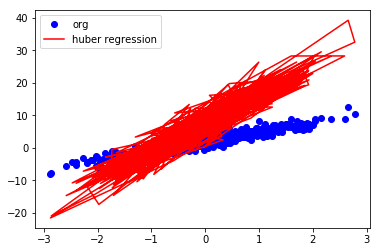

In [41]:
import matplotlib.pyplot as plt
plt.plot(X, y, 'bo',label='org')
plt.plot(X, y * W.numpy() + b.numpy(), 'r',
         label="huber regression")
plt.legend()
plt.show

# Things to Do[Homework Part 1             Point = 3]
NOTE:- All submissions should use NIPS latex template [https://nips.cc/Conferences/2019/PaperInformation/StyleFiles].
Pdf generated from NIPS template would only be accepted rest all would lead to zero points.

  * Fork repo [https://github.com/AnkurMali/IST597_Fall2019_TF2.0] and modify file lin_reg.py.
  * Change the loss function,which loss function works better and why?Write mathematical formulation for each loss function
  * Create hybrid loss function(For eg. L1 + L2)
  * Change the learning rate.
  * Use patience scheduling[Whenever loss do not change , divide the learning rate by half].
  * Train for longer Duration.
  * Change the initial value for W and B.What effect it has on end result?
  * Change the level of noise.
  * Use various type of noise.
  * Add noise in data.
  * Add noise in your weights.
  * Add noise in your learning rate[For all above: Scheme can be per  epoch or per N epochs]
  * How do these changes effect the performance?
  * Do you think these changes will have the same effect (if any) on other classification problems and mathematical models?
  * Plot the different result.
  * Do you get the exact same results if you run the Notebook multiple times without changing any parameters? Why or why not?[Explain significance of seed].
  * Use unique seed for each experiment[Note:- Convert your first name into decimal].
  * Later report per epoch GPU vs CPU Time.
  * Can you get an model which is robust to noise?Does model lead to faster convergence?Do you get better local minima?Is noise beneficial?  
  * Collect everything and report your findings.


#Part-2 Logistic Regression [Point =5 ]

Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.
In this you will be using Fashion Mnist which is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classe[https://github.com/zalandoresearch/fashion-mnist].FashionMnist is much harder than MNIST so getting accuracy in 90's is difficult. You can use whatever loss functions, optimizers, even models that you want, as long as your model is built in TensorFlow using eager execution[Remember no keras is allowed]

#Things to Report

* Fork repo [https://github.com/AnkurMali/IST597_Fall2019_TF2.0] and modify file log_reg.py.
* TODO: This keyword means you have to implement specific section/function/formula.
* Report should contain matplotlib plots from function plot_images and plot_weights.
* Change the optimizer and report which one converges faster and which one reaches better local minima/generalizes better.[Now you can use tensorflow optimizer]
* Train for longer epochs.
* Change Train/Val split.Report if you observe any performance drop/gain.
* Report Train/Val accuracy over time.
* Does batch size have any effect on performance.
* Report GPU vs CPU per epoch performance.
* Do Model overfit?If so why and also report measures you took to avoid overfitting.
* Bonus points[Cluster the weights using any clustering mechanism].

